# Visualising CNN feature-maps and layer activations for MNIST

Convolutional Neural Networks are the most successful deep learning architecture for Computer Vision tasks, particularly image classification. They comprise of a stack of *Convolutional layers,* *Pooling layers* and *Fully-connected layers*. For an outstanding and clear introduction to CNNs for Deep Learning, visit the Stanford CS231n notes [here](https://cs231n.github.io/).

We build a simple Convolutional Neural Network in PyTorch, trained to recognise hand-written digits using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and focus on examining the *Convolutional layers*. 

Each filter, or kernel, learns a particular feature of the dataset. After passing over an image, a filter produces a feature map which we can visualise. In this post, I explain how to produce the following visualisations of our CNN layers, helping us to interpret our model better:


*   Feature map for each convolutional layer, showing activations for a single image.
*   Average activations of each Feature over the entire training set.
* Histogram of average activations of each Feature.







In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seeds
np.random.seed(0)
torch.manual_seed(0)

cuda


## Load Data
MNIST consists of 70,000 greyscale 28x28 images (60,000 train, 10,000 test). We use inbuilt torchvision functions to create our DataLoaders for the model in two stages:

1.   Download the dataset using torchvision.datasets. Here we can transform the data, turning it into a tensor and normalising the greyscale values with zero mean and unit standard deviation (the values 0.1307 and 0.3081 are the global mean/std for the MNIST images, these will be different according to your dataset). Since our images are already centered we need no more preprocessing but there's a whole suite of transformations in this class (e.g. RandomHorizontalFlip, CenterCrop, Scale to list a few).

2.   Create a DataLoader from the Datasets object, with a different batch size for training and validation (larger since more examples can be processed in parallel at inference time).

The Datasets object allows us easily to access class names, which we use later.




In [ ]:
# set transformations
transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# inputs into Datasets object
root_dir = '../visual_cnn/data/'
download_train= {'train': True, 'val': False}
batch_size = {'train': 256, 'val': 1024}

# create train and validation Datasets object
image_datasets = {x: torchvision.datasets.MNIST(root=root_dir+'/'+x+'/',
                                                train=download_train[x],
                                                transform=transformations,
                                                download=True) for x in ['train', 'val']}

# create DataLoader objects
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size[x],
                                              shuffle=True) for x in ['train', 'val']}

# get class names
class_names = image_datasets['train'].classes
class_labels = list(image_datasets['train'].class_to_idx.values())
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


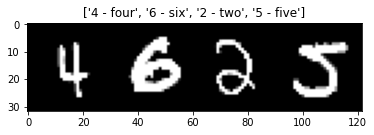

<Figure size 432x288 with 0 Axes>

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.savefig('sample_images.jpg')

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
# _sum=0
# for parameter in model.parameters():
#     _sum += len(parameter)
# print(_sum)

# params_to_update = model.parameters()
# print("Params to learn:")

# params_to_update = []
# for name,param in model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
#         print("\t",name)

## Constructing our model



In [ ]:
class CNN(nn.Module):
    def __init__(self, dropout=0, dropout2d=0):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.Dropout = nn.Dropout(p=dropout)
        self.Dropout2d = nn.Dropout2d(p=dropout2d)

    def forward(self, x):
        # first convolutional layer
        x = self.Dropout2d(self.pool(F.relu(self.conv1(x))))
        # second convolutional layer
        x = self.Dropout2d(self.pool(F.relu(self.conv2(x))))
        x = x.view(-1, 16 * 7 * 7)
        x = self.Dropout(F.relu(self.fc1(x)))
        x = self.Dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
def save_checkpoint(state, ep, filename='checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    print("=> Saving a new best at epoch:", ep)
    torch.save(state, filename)  # save checkpoint

In [ ]:
def train(model, lossFun, optim, scheduler, n_epochs, train_loader, val_loader, saveModel=False, verbose=False):
    """Train CNN model"""

    print("Summary of model\n")
    print(model)
    print("\n")

    # initialize lists to store loss and accuracy
    trainLossVec , valLossVec, trainAccuracyVec, valAccuracyVec = [], [], [], []
    bestLoss, bestEpoch = 100, 0

    # get number of batches
    numberBatches = len(train_loader)

    for epoch in range(n_epochs):

        # Set model to training mode
        model.to(device)
        model.train()
    
        # Loop over each batch from the training set
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            
            # Zero gradient buffers
            optim.zero_grad()
            # Foward pass and compute loss on batch
            outputs = model(inputs.to(device))
            batchloss = lossFun(outputs, targets.long().to(device)) #commen
            # Backpropagate and update weights
            batchloss.backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(m.parameters(), 1., norm_type=2)
            # optimizer step
            optim.step()
    
        # set model to evaluation mode
        model.eval()
        with torch.no_grad():
            # evaluate model on training and validation data
            acc, loss = evaluate(model, {"train": train_loader, "val": val_loader}, lossFun)
            # update accuracy
            trainAccuracyVec.append(acc["train"])
            valAccuracyVec.append(acc["val"])
            # update loss
            trainLossVec.append(loss["train"])
            valLossVec.append(loss["val"])
            
            if scheduler != None:
                scheduler.step()
    
            # check if new best for validation accuracy
            if valLossVec[-1] < bestLoss:
                bestLoss = valLossVec[-1]
                bestEpoch = epoch
                if saveModel == True:
                    torch.save(m.state_dict(), "bestModel.pt")
                    print("New best value for validation loss: Saved model to bestModel.pt")
            
            # print information about training progress
            if verbose == True:
                print(("Epoch: {} \t Loss (train): {:.3f} (val): {:.3f} \t" +
              "Acc (train) {:.3f} (val): {:.3f}").format(epoch + 1,
                            trainLossVec[-1], valLossVec[-1], trainAccuracyVec[-1], valAccuracyVec[-1]))
            # clean up
            del inputs, targets, outputs, acc, loss

    return trainLossVec, valLossVec, trainAccuracyVec, valAccuracyVec, bestEpoch

In [ ]:
def evaluate(model, dataDict, lossFun):
    """Calculate loss + accuracy of specified Dataloaders"""
    # extract data objects
    keys = list(dataDict.keys())
    values = [0] * len(keys)

    acc = dict(zip(keys, values))
    lossDict = dict(zip(keys, values))

    # set model to evaluate model
    model.to(device)
    model.eval()
    # stop tracking gradients
    with torch.no_grad():
        # loop over specified dataloaders
        for data in dataDict.keys():
            lossVal = 0
            correct = 0
        
            for (inputs, targets) in dataDict[data]:
                batchsize = len(targets)
                outputs = model(inputs.to(device))

                # times by batchsize to scale up total loss correctly
                lossVal += lossFun(outputs, targets.long().to(device)).item()*batchsize
                _, pred = torch.max(outputs.data, 1)
                correct += (pred == targets.long().to(device)).sum().item()
            
            # store values
            lossVal = lossVal/len(dataDict[data].dataset)
            accuracy = correct/len(dataDict[data].dataset)
            acc[data] = accuracy * 100
            lossDict[data] = lossVal

            # clean up
            del inputs, targets, outputs

    return acc, lossDict

## Train Model

We're now ready to train our model! Our task of multi-class classification lends itself to a cross-entropy loss - `PyTorch` attaches a softmax layer to your model when this loss is used. We use [AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) as our optimiser and use a scheduler to taper the learning rate.

In [ ]:
model = CNN(0.1, 0.1) 
lr = 1e-03 
loss_function = nn.CrossEntropyLoss() 
optimiser = optim.AdamW(model.parameters(), lr=lr)
n_epochs = 10
scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=0.995) 

In [ ]:
trainLossVec, valLossVec, trainAccuracyVec, valAccuracyVec, bestEpoch = train(model, 
                                                                              loss_function, 
                                                                              optimiser, 
                                                                              scheduler, 
                                                                              n_epochs, 
                                                                              dataloaders['train'], 
                                                                              dataloaders['val'], 
                                                                              saveModel=True, 
                                                                              verbose=True)

Summary of model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (Dropout): Dropout(p=0.1, inplace=False)
  (Dropout2d): Dropout2d(p=0.1, inplace=False)
)


New best value for validation loss: Saved model to bestModel.pt
Epoch: 1 	 Loss (train): 0.128 (val): 0.123 	Acc (train) 96.057 (val): 96.260
New best value for validation loss: Saved model to bestModel.pt
Epoch: 2 	 Loss (train): 0.071 (val): 0.065 	Acc (train) 97.810 (val): 97.900
New best value for validation loss: Saved model to bestModel.pt
Epoch: 3 	 Loss (train): 0.055 (val): 0.056 	Acc (train) 98.293 (val): 98.140
New best value for validation loss: Sa

## Visiualising the learnt feature maps



In [ ]:
# load model
with torch.no_grad():
    model = CNN(0.1, 0.1)
    model.load_state_dict(torch.load('bestModel.pt'))

In [ ]:
# get data
imgs, labels = next(iter(dataloaders['train']))
class_index = []
# select an example from each catagory
for i in class_labels:
    class_index.append((labels==i).nonzero()[0])
class_index = torch.tensor(class_index)
data = imgs[class_index,:,:,:]

In [ ]:
# hook relevant activations
activations = {}
def get_activations(name):
    """Create hook function for layer given"""
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activations("conv1"))
model.conv2.register_forward_hook(get_activations("conv2"))
output = model(data)

def showActivations(data, activations, plot_size=(20,7), same_scale=False):
    """Plot feature map for each example digit"""
    fig, axarr = plt.subplots(activations.size(0), activations.size(1)+1, figsize=plot_size)

    # extract max/min values to scale
     images
    if same_scale: 
        vmin = activations.min()
        vmax = activations.max() 

    for digit in range(activations.size(0)):
        # show original images
        axarr[digit, 0].imshow(data[digit,0], cmap='gray')
        axarr[digit, 0].set_xticks([])
        axarr[digit, 0].set_yticks([])
        axarr[digit, 0].set_ylabel(class_names[digit])

        # show features
        for feature in range(activations.size(1)):
            if same_scale: 
              axarr[digit, feature+1].imshow(activations[digit, feature], cmap='gray', vmin=vmin, vmax=vmax)
            else: 
              axarr[digit, feature+1].imshow(activations[digit, feature], cmap='gray')
            axarr[digit, feature+1].set_xticks([])
            axarr[digit, feature+1].set_yticks([])
            if digit == 0:
                axarr[digit, feature+1].set_title("Feature "+str(feature+1))
    
    # set axis title
    axarr[0,0].set_title("Original")

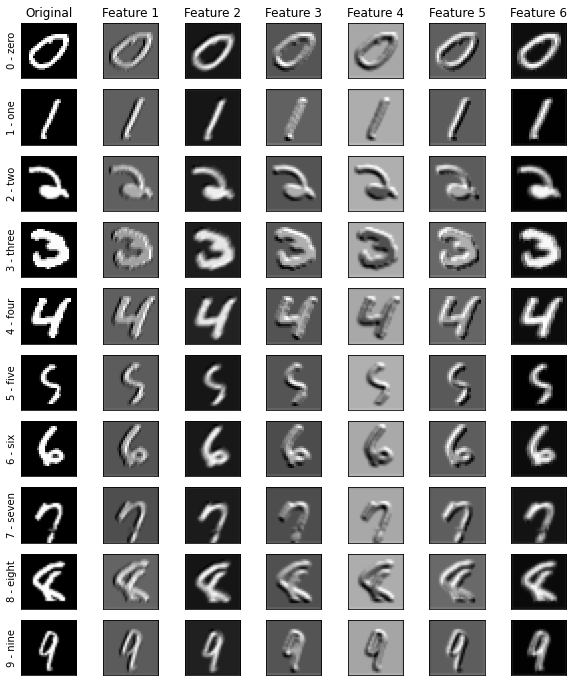

In [ ]:
act1 = activations["conv1"]
showActivations(act1, plot_size=(10,12), same_scale=False)
plt.savefig('layer_1_activations.jpg')

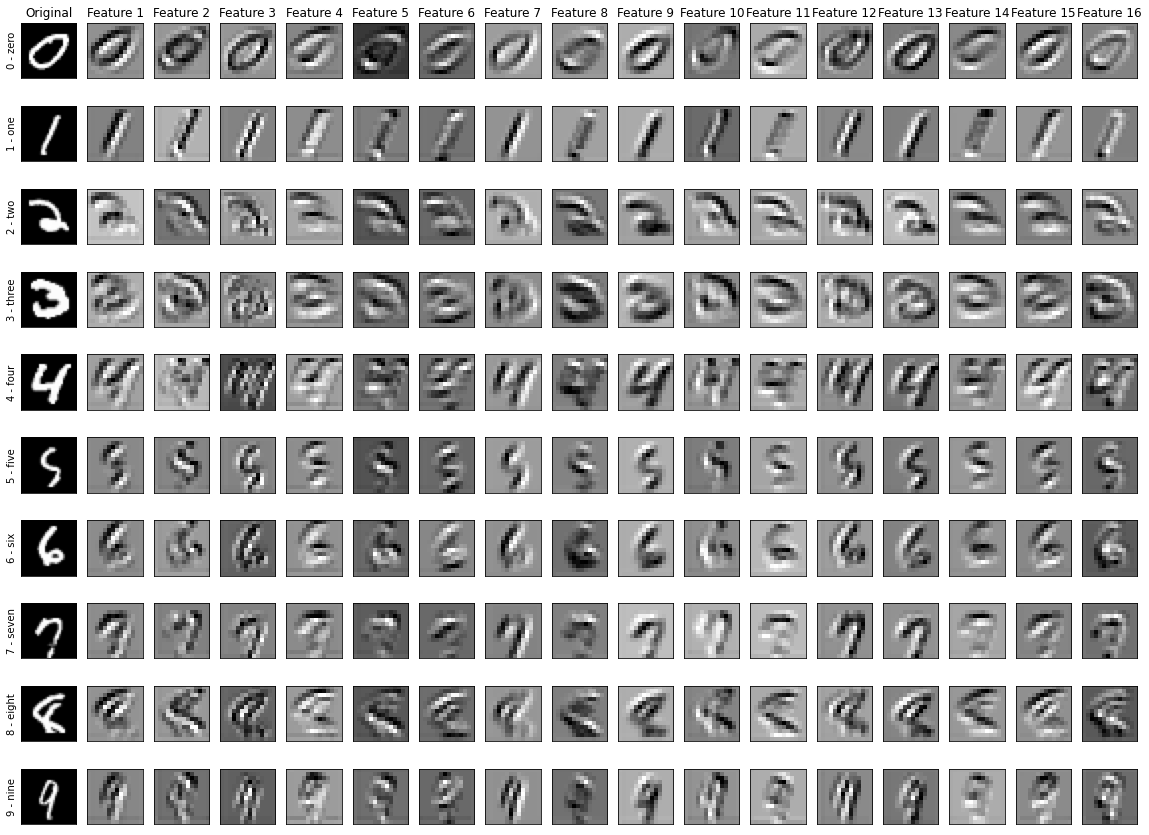

In [ ]:
act2 = activations["conv2"]
showActivations(act2, plot_size=(20,15), same_scale=False)
plt.savefig('layer_2_activations.jpg')

In [ ]:
avgAct = torch.zeros((10, 16, 14, 14))
avgOriginals = torch.zeros((10,1,28,28))
# create dataloader of full training set in single batch
train_dataloader_full = torch.utils.data.DataLoader(image_datasets['train'], 
                                                    batch_size=len(image_datasets['train']),
                                                    shuffle=True)
imgs, labels = next(iter(train_dataloader_full))
for digit in class_labels:
    idx = (labels==digit).nonzero().squeeze()
    data = imgs[idx]
    avgOriginals[digit] = data.sum(0)
    output = model(data)
    avgAct[digit] = F.relu(activations["conv2"]).sum(0)
data = avgOriginals

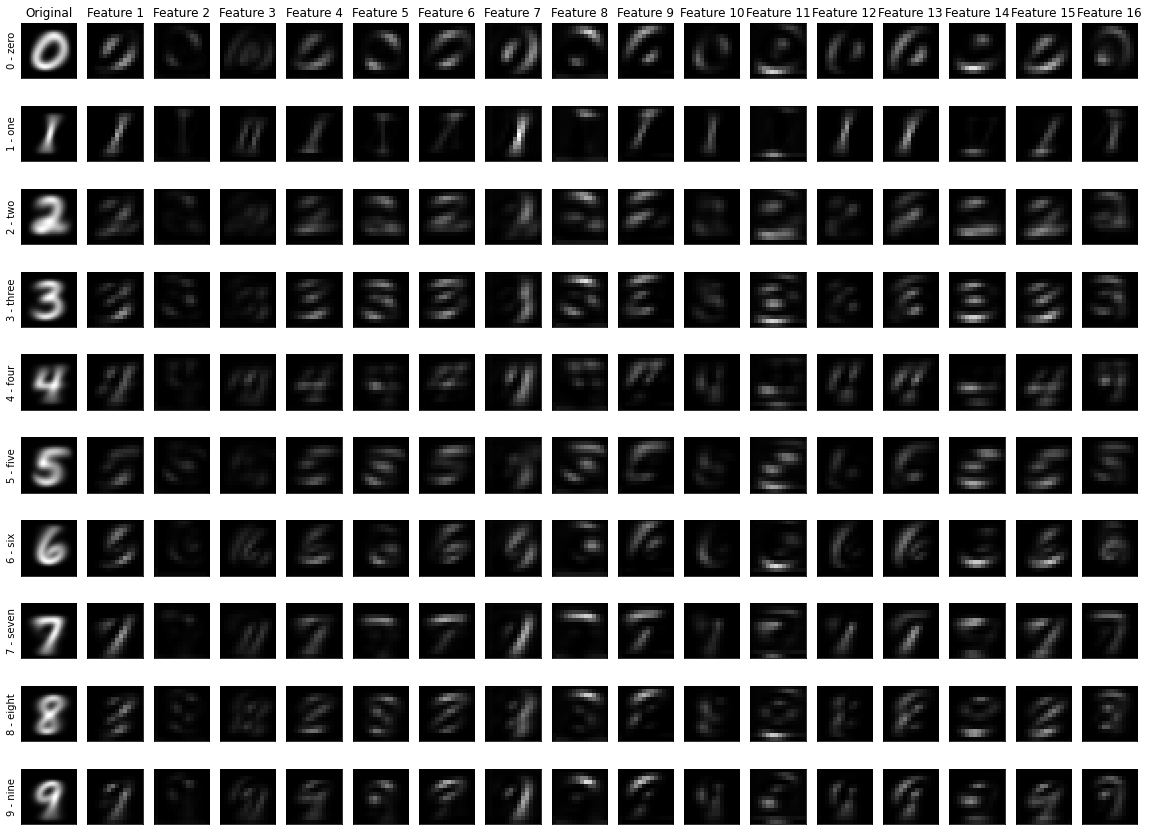

In [ ]:
showActivations(data, avgAct, plot_size=(20,15), same_scale=True)
plt.savefig('average_activations.jpg')

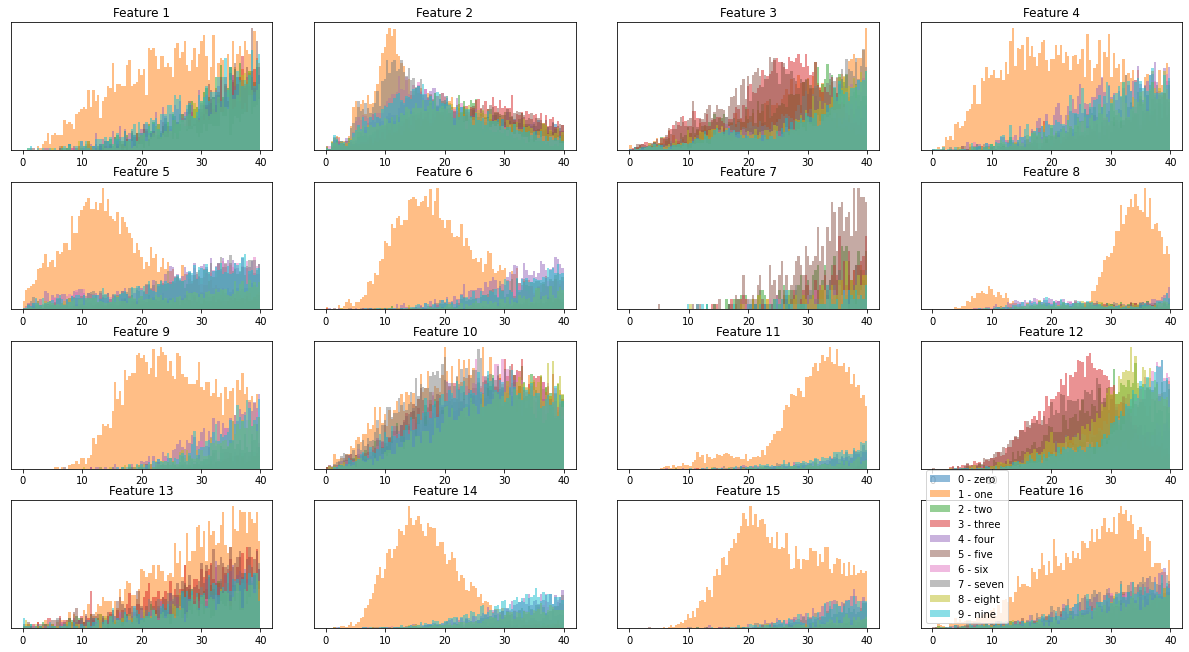

In [ ]:
avgAct = []
# select an example from each catagory
# load all training data into one batch
train_dataloader_full = torch.utils.data.DataLoader(image_datasets['train'], 
                                                    batch_size=len(image_datasets['train']),
                                                    shuffle=True)

imgs, labels = next(iter(train_dataloader_full))
for digit in class_labels:
    idx = (labels==digit).nonzero().squeeze()
    data = imgs[idx]
    output = model(data)
    avgAct.append(F.relu(activations["conv2"]).sum((2,3)))

bins = np.linspace(0, 40, 100)
fig, axarr = plt.subplots(4, 4, figsize=(17,9))
plt.tight_layout()

for i in range(4):
    for j in range(4):
        axarr[i, j].set_title("Feature "+str(4*i+j+1))
        axarr[i, j].set_yticks([])
        for k in range(len(class_labels)):
            axarr[i, j].hist(avgAct[k][:, 4*i+j], bins, alpha=0.5, label=class_names[k])
plt.legend()
plt.savefig('hist_activations.jpg')
plt.show()